In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn import metrics

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
df = pd.read_csv("food_choices.csv")
selected_columns = ['comfort_food', 'comfort_food_reasons', 'Gender', 'cook', 'employment']
df = df[selected_columns]

In [17]:
def map_employment(value):
    if value == 2:
        return 1
    elif value == 3:
        return 2
    else:
        return 2

In [18]:
df['employment'] = df['employment'].apply(map_employment)

In [19]:
df['comfort_food'].fillna('unknown', inplace=True)
df['comfort_food_reasons'].fillna('unknown', inplace=True)
mode_coded = df['cook'].mode()[0]
df['cook'].fillna(mode_coded, inplace=True)
mode_coded = df['Gender'].mode()[0]
df['Gender'].fillna(mode_coded, inplace=True)

missing_values = df.isnull().sum()
print("Missing values after handling:\n", missing_values)

Missing values after handling:
 comfort_food            0
comfort_food_reasons    0
Gender                  0
cook                    0
employment              0
dtype: int64


In [20]:
def categorize_food(food):
    food = food.lower()
    if any(keyword in food for keyword in ['fruit', 'vegetable', 'grapes', 'carrots', 'broccoli', 'tomato soup', 'spaghetti squash', 'carrots', 'plantain chips', 'almonds', 'watermelon', 'cucumber', 'fritos']):
        return 'Fruit and Vegetables'
    elif any(keyword in food for keyword in ['pizza', 'pasta', 'spaghetti', 'noodles', 'rice', 'potatoes', 'bagels', 'fries', 'taco', 'sandwich', 'hot dog', 'burrito', 'sub', 'macaroni and cheese', 'lasagna', 'mashed potatoes', 'spaghetti squash', 'stuffed peppers', 'meatball sub', 'chicken tikka masala', 'chicken noodle soup', 'chicken pot pie']):
        return 'Starchy food'
    elif any(keyword in food for keyword in ['milk', 'cheese', 'yogurt', 'ice cream', 'mozzarella sticks', 'cottage cheese', 'cheesecake', 'frozen yogurt']):
        return 'Dairy'
    elif any(keyword in food for keyword in ['chicken', 'beef', 'pork', 'fish', 'egg', 'turkey', 'meatball', 'sausage', 'fried chicken', 'grilled chicken', 'chicken fingers', 'beef jerky', 'steak']):
        return 'Protein'
    elif any(keyword in food for keyword in ['chips', 'fries', 'chocolate', 'cake', 'cookie', 'brownie', 'candy', 'soda', 'donut', 'peanut butter', 'burgers', 'garlic bread', 'popcorn', 'pretzels', 'chicken wings', 'doughnut', 'chocolate bar', 'twizzlers', 'chocolate brownie', 'macaroons', 'truffles', 'french fries', 'slim jims', 'chicken curry', 'chocolate chipotle', 'pop', 'mac n cheese', 'rice', 'pizza', 'cheeseburger', 'chicken nuggets', 'peanut butter sandwich', 'mac and cheese', 'cheese and crackers', 'protein bar', 'chex mix', 'cheez-its', 'chicken fingers', 'chips and cheese', 'chips and dip', 'fruit snacks', 'doritos']):
        return 'Fat'
    else:
        return 'Others'

In [21]:
df['food_group'] = df['comfort_food'].apply(categorize_food)

In [22]:
def map_reasons_to_mood(reasons):
    reason_to_mood = {
        'stress': 'stress',
        'anxiety': 'anxiety',
        'stress': 'anxiety',
        'anxiety': 'stress',
        'boredom': 'boredom',
        'sadness': 'sadness',
        'happiness': 'happiness',
        'celebration': 'celebration',
        'happiness': 'celebration',
        'celebration': 'happiness',
        'other': 'neutral',
        'none': 'neutral',
        'unknown': 'neutral'
    }
    
    reasons_list = [r.strip().lower() for r in reasons.split(',')]
    
    mood_categories = [reason_to_mood.get(reason, 'neutral') for reason in reasons_list]
    
    return mood_categories

In [23]:
df['mood_category'] = df['comfort_food_reasons'].apply(map_reasons_to_mood)

In [24]:
df_exploded = df.explode('mood_category')
X = df_exploded[['mood_category', 'Gender', 'cook', 'employment']]
y = df_exploded['food_group']

In [25]:
# Descriptive Statistics for Numerical Columns
numerical_summary = df.describe()
print("Descriptive Statistics for Numerical Columns:\n", numerical_summary)

# Descriptive Statistics for Categorical Columns
categorical_columns = ['comfort_food', 'comfort_food_reasons', 'Gender', 'cook', 'employment', 'food_group', 'mood_category']
for column in categorical_columns:
    print(f"Value Counts for {column}:\n", df[column].value_counts())
    print(f"Mode for {column}: {df[column].mode()[0]}\n")

# Summary Statistics for Exploded Data
print("Summary Statistics for Exploded Data:\n", df_exploded.describe(include='all'))

Descriptive Statistics for Numerical Columns:
            Gender        cook  employment
count  125.000000  125.000000   125.00000
mean     1.392000    2.792000     1.52000
std      0.490161    1.026236     0.50161
min      1.000000    1.000000     1.00000
25%      1.000000    2.000000     1.00000
50%      1.000000    3.000000     2.00000
75%      2.000000    3.000000     2.00000
max      2.000000    5.000000     2.00000
Value Counts for comfort_food:
 none                                                                                                 1
Chips sweets popcorn                                                                                 1
Chocolate, Chips, Ice cream, French Fires, Pizza                                                     1
Macaroni and cheese, chicken noodle soup, pizza                                                      1
chips, ice cream, fruit snacks                                                                       1
carrots, plantain chips, alm

In [26]:
ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [28]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear']
}

classifiers = {
    "LogisticRegression": GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5),
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5)
}

In [29]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:\n", report)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy}\n")

    model_filename = f"{name}_model.pkl"
    joblib.dump(clf, model_filename)
    print(f"Saved {name} model to {model_filename}")

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classifica

Classification Report for LogisticRegression:
                       precision    recall  f1-score   support

               Dairy       0.21      0.33      0.26         9
                 Fat       0.75      0.43      0.55         7
Fruit and Vegetables       0.00      0.00      0.00         5
             Protein       0.00      0.00      0.00         2
        Starchy food       0.62      0.74      0.68        27

            accuracy                           0.52        50
           macro avg       0.32      0.30      0.30        50
        weighted avg       0.48      0.52      0.49        50

Accuracy for LogisticRegression: 0.52

Saved LogisticRegression model to LogisticRegression_model.pkl
Classification Report for GradientBoosting:
                       precision    recall  f1-score   support

               Dairy       0.38      0.33      0.35         9
                 Fat       1.00      0.14      0.25         7
Fruit and Vegetables       0.00      0.00      0.00       

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

In [30]:
preprocessed_file = "preprocessed_data.csv"
df.to_csv(preprocessed_file, index=False)
print(f"Preprocessed data saved to {preprocessed_file}")

Preprocessed data saved to preprocessed_data.csv


In [31]:
encoder_filename = "one_hot_encoder.pkl"
joblib.dump(ohe, encoder_filename)
print(f"Saved OneHotEncoder to {encoder_filename}")

Saved OneHotEncoder to one_hot_encoder.pkl


In [32]:
# joblib.dump(training_artifacts, "training_artifacts.joblib")
# print("Training artifacts saved")

In [33]:
# joblib.dump(ohe, 'one_hot_encoder.pkl')
# # joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
# print("Saved preprocessors to one_hot_encoder.pkl")

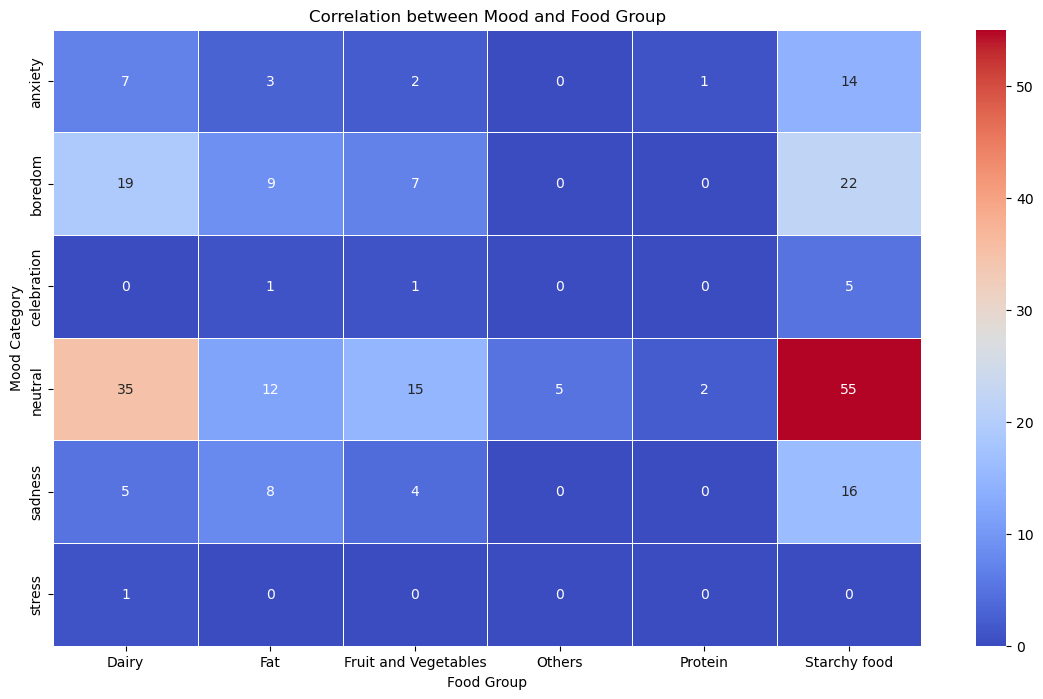

In [34]:
plt.figure(figsize=(14, 8))
food_mood_corr = df_exploded.groupby(['mood_category', 'food_group']).size().unstack().fillna(0)
sns.heatmap(food_mood_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Mood and Food Group')
plt.ylabel('Mood Category')
plt.xlabel('Food Group')
plt.show()

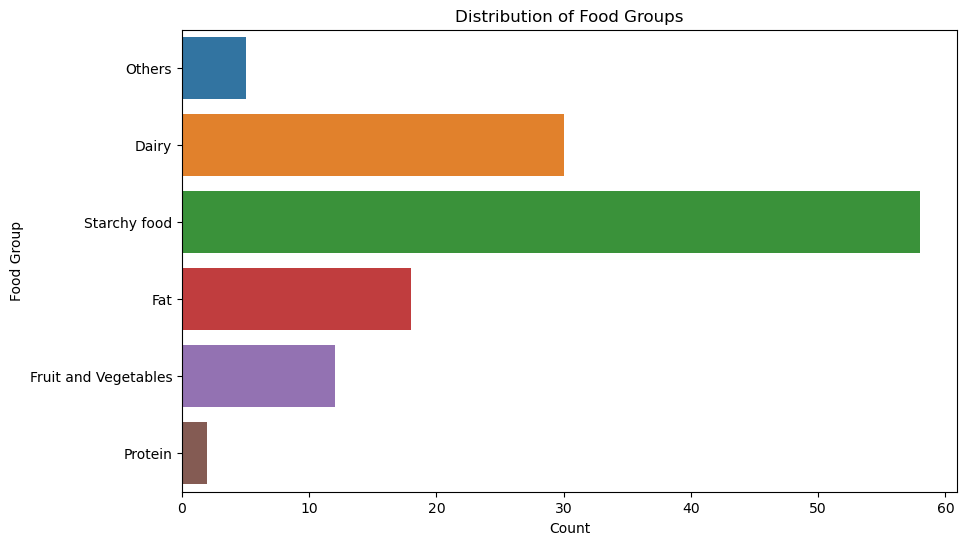

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(y='food_group', data=df)
plt.title('Distribution of Food Groups')
plt.xlabel('Count')
plt.ylabel('Food Group')
plt.show()

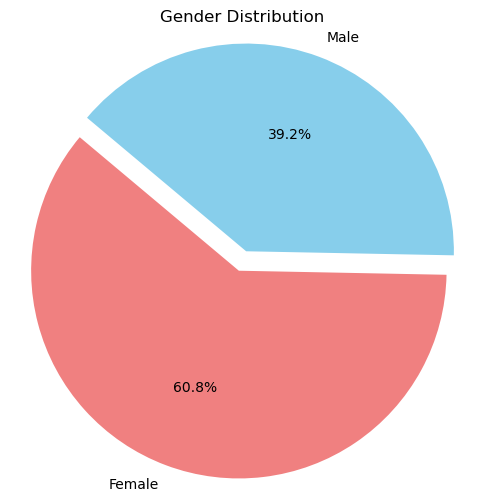

In [36]:
gender_mapping = {1: 'Female', 2: 'Male'}
df['Gender'] = df['Gender'].map(gender_mapping)

plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'skyblue'], explode=(0.1, 0), startangle=140)
plt.title('Gender Distribution')
plt.ylabel('')
plt.axis('equal')
plt.show()

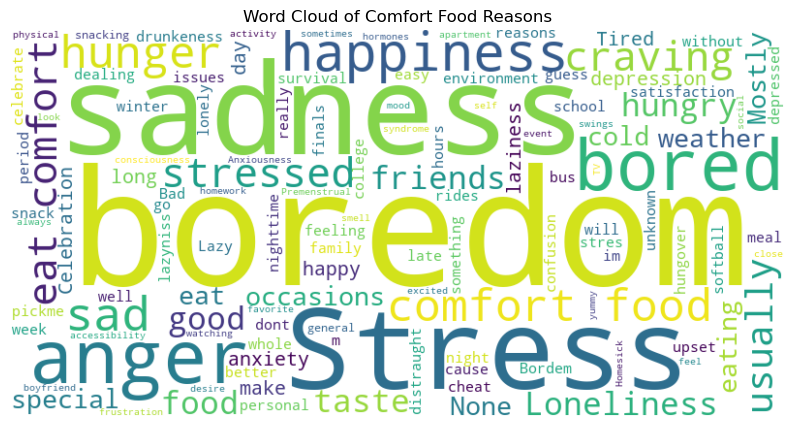

In [37]:
comfort_food_reasons_text = df['comfort_food_reasons'].astype(str).values
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(comfort_food_reasons_text))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Comfort Food Reasons')
plt.axis('off') 
plt.show()

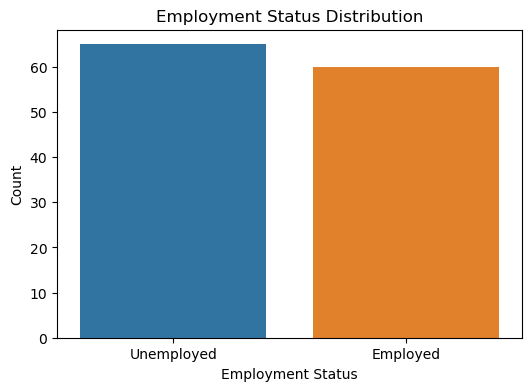

In [38]:
plt.figure(figsize=(6, 4))
sns.countplot(x='employment', data=df.replace({'employment': {1: 'Employed', 2: 'Unemployed'}}))
plt.title('Employment Status Distribution')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

In [40]:
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_encoded, y, cv=5)
    print(f"Cross-Validation Scores for {name}: {scores}")
    print(f"Mean Cross-Validation Score for {name}: {scores.mean()}\n")

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least

Cross-Validation Scores for LogisticRegression: [0.46       0.42       0.46       0.42       0.32653061]
Mean Cross-Validation Score for LogisticRegression: 0.41730612244897963



C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least

Cross-Validation Scores for GradientBoosting: [0.44       0.26       0.34       0.42       0.44897959]
Mean Cross-Validation Score for GradientBoosting: 0.38179591836734694

